# Fitting Functional Response Models in Python

**TODO:**
1. With the parameter sampling, cut the sampling after 5 or so higher AIc values are found in a row
1. Take a random subset of the data (10 IDs or something)
2. Fit models (minus quadratic) with current method (extracting $R^2$ as well as an extra more standard comparison)
3. Extract params for best fits
4. Plot in R
    * If plots are crappy, then it's likely a model formulation issue
    * If plots are fine and aics are silly then it's an AIC issue (use python's inbuilt AIC calc)
5. Compare stats csv to plots! If AIC is acceptable, move tf on!!!

For each ID:

For each model:
1. Obtain sensible start values for params (in some generalised way)
2. Optimise param values 
    * For each value in a certain distribution around the start value, try to fit, record AIC
    * Take parameter combo that generated the lowest AIC
    * This step should be vectorised/parallised to the extent possible (consider multiprocessing and numpy)
    * Refit
3. Write relevant statistics (AIC/BIC) to dataframe

#### Imports:

In [69]:
import statsmodels.formula.api as smf
from statistics import mean
from lmfit import Minimizer, Parameters, report_fit
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pylab as plt

#### Load and view data:

In [60]:
# Load
data = pd.read_csv("../Data/CRat_prepped.csv")

# Subset
df = data[data['ID'] == 140]

# View
df

,ID,ResDensity,N_TraitValue,ResDensityUnit,TraitUnit
4047,140,18.0,0.0429,individual per arena (1),individual / (1 individual * 1 second)
4048,140,180.0,0.1572,individual per arena (1),individual / (1 individual * 1 second)
4049,140,360.0,0.2360,individual per arena (1),individual / (1 individual * 1 second)
4050,140,45.0,0.0816,individual per arena (1),individual / (1 individual * 1 second)
4051,140,720.0,0.2495,individual per arena (1),individual / (1 individual * 1 second)
4052,140,90.0,0.1213,individual per arena (1),individual / (1 individual * 1 second)


In [61]:
# Extract exp/resp variables
x = df['ResDensity']
y = df['N_TraitValue']

## Fit linear models


#### Note:
* THESE AIC VALUES ARE DIFFERENT FROM R

In [19]:
# Quadratic Polynomial
quad = np.poly1d(np.polyfit(x, y, 2))
quad_stats = smf.ols(formula='N_TraitValue ~ quad(ResDensity)', data=df).fit() # Obtain OLS stats
print(f'Quadratic AIC:\t{quad_stats.aic}')

# Cubic Polynomial
cube = np.poly1d(np.polyfit(x, y, 3))
cube_stats = smf.ols(formula='N_TraitValue ~ cube(ResDensity)', data=df).fit() # Obtain OLS stats
print(f'Cubic AIC:\t{cube_stats.aic}')

Quadratic AIC:	-36.5641666734528
Cubic AIC:	-37.675720142384534


## Fit non-linear models

#### Start parameter values

In [58]:
def startValues(df):
    """return sensible start values for params
    """
    # h
    h = max(df['N_TraitValue'])
    
    # a
    BelowMean = df[df['N_TraitValue'] < mean(df['N_TraitValue'])]
    slope1, _, r_value1, _, _ = sc.stats.linregress(BelowMean['ResDensity'], BelowMean['N_TraitValue'])
    r_sqd1 = r_value1**2
    
    BelowMax = df[df['N_TraitValue'] < max(df['N_TraitValue'])]
    slope2, _, r_value2, _, _ = sc.stats.linregress(BelowMax['ResDensity'], BelowMax['N_TraitValue'])
    r_sqd2 = r_value2**2
    
    a = slope1 if r_sqd1 > r_sqd2 else slope2
    
    # q
    q = 0
    
    return h, a, q

def residuals_holl2(params, x, y):
    '''Returns residuals for Holling II functional response:
    
    Arguments:
     - params: parameters
     - x: Resource density data values
     - y: Corresponding N_TraitValue data values
    '''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    
    #Holling II model
    model = (v['a']*x)/(1+v['h']*v['a']*x)
    
    #Return residuals
    return model - y

def fitHollingII(h, a, x, y):
    """Fit Holling II to data with start values
    
    h: handling time
    a: attack rate
    x: ResDensity (vec)
    y: N_TraitValue (vec)
    """
    # store paramteters
    params_holl2 = Parameters() # Create object for parameter storing
    params_holl2.add('h', value = h) # Add h param
    params_holl2.add('a', value = a) # Add a param
    
    # Create a Minimizer object
    minner = Minimizer(residuals_holl2, params_holl2, fcn_args=(x, y)) #Plug in the data for this curve.
    
    # Perform the minimization
    fit_holl2 = minner.minimize(method = 'leastsq')

    # Get summary of the fit
    return report_fit(fit_holl2)

h:

In [62]:
h = max(df['N_TraitValue'])
print(f'h: {h}')

h: 0.2495


a:

In [63]:
# Subset the data 
BelowMean = df[df['N_TraitValue'] < mean(df['N_TraitValue'])]
BelowMax = df[df['N_TraitValue'] < max(df['N_TraitValue'])]

# Mean
slope1, _, r_value1, _, _ = sc.stats.linregress(BelowMean['ResDensity'], BelowMean['N_TraitValue'])
r_sqd1 = r_value1**2

# Max
slope2, _, r_value2, _, _ = sc.stats.linregress(BelowMax['ResDensity'], BelowMax['N_TraitValue'])
r_sqd2 = r_value2**2

# Estimate
a = slope1 if r_sqd1 > r_sqd2 else slope2

print(f"a = {a}")

a = 0.0010678004535147393


### Fit Holling II

In [70]:
def Holling2(x, a, h):
    """Returns Holling II functional response:
    """
    return (a * x) / (1 + h * a * x)

In [68]:
params_holl2 = Parameters() # Create object for parameter storing
params_holl2.add('h', value = h) # Add h param
params_holl2.add('a', value = a) # Add a param

# Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_holl2(params, x, data):
    '''Returns residuals for Holling II functional response:
    
    Arguments:
     - params: parameters
     - x: Resource density data values
     - data: Corresponding N_TraitValue data values
    '''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    
    #Holling II model
    model = (v['a']*x)/(1+v['h']*v['a']*x)
    
    #Return residuals
    return model - data

# Create a Minimizer object
minner = Minimizer(residuals_holl2, params_holl2, fcn_args=(x, y)) #Plug in the data for this curve.

# Perform the minimization
fit_holl2 = minner.minimize(method = 'leastsq')

# Get summary of the fit
report_fit(fit_holl2)


n = fit_holl2.ndata
p = fit_holl2.nfree
rss = sum(fit_holl2.residual**2)

#print(n, p, rss)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 6
    # variables        = 2
    chi-square         = 6.1486e-04
    reduced chi-square = 1.5372e-04
    Akaike info crit   = -51.1152364
    Bayesian info crit = -51.5317175
[[Variables]]
    h:  3.32544455 +/- 0.20764816 (6.24%) (init = 0.2495)
    a:  0.00228167 +/- 2.9423e-04 (12.90%) (init = 0.0010678)
[[Correlations]] (unreported correlations are < 0.100)
    C(h, a) =  0.732


In [66]:
fit_holl2

### Fit Holling III

In [71]:
def Holling3(x, a, h, q):
    """Returns Holling III functional response:
    """
    return (a * x**(q+1)) / (1 + h * a * x**(q+1))

In [ ]:
# Holling III
params_holl3 = Parameters() # Create object for parameter storing
params_holl3.add('h', value = h) # Add h param
params_holl3.add('a', value = a) # Add a param
params_holl3.add('q', value = a) # Add a param


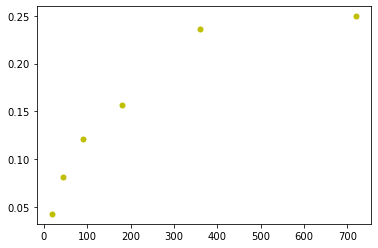

In [79]:
plt.plot(x, y, 'y.', markersize = 10, label = 'Linear')

xvals = np.linspace(min(x), max(x), 100)



# Holling III


In [ ]:
result_linear = np.log(N_rand) + fit_linear_NLLS.residual # These points lay on top of the theoretical fitted curve
plt.plot(t, result_linear, 'y.', markersize = 15, label = 'Linear')

#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))#Create a vector of ones.
residual_smooth_linear = residuals_linear(fit_linear_NLLS.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_linear + log_N_vec, 'orange', linestyle = '--', linewidth = 1)

#Logistic
result_logistic = np.log(N_rand) + fit_logistic.residual
plt.plot(t, result_logistic, 'b.', markersize = 15, label = 'Logistic')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_logistic = residuals_logistic(fit_logistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_logistic + log_N_vec, 'blue', linestyle = '--', linewidth = 1)

#Gompertz
result_gompertz = np.log(N_rand) + fit_gompertz.residual
plt.plot(t, result_gompertz, 'g.', markersize = 15, label = 'Gompertz')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_gompertz = residuals_gompertz(fit_gompertz.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_gompertz + log_N_vec, 'green', linestyle = '--', linewidth = 1)

#Plot data points
plt.plot(t, np.log(N_rand), 'r+', markersize = 15,markeredgewidth = 2, label = 'Data')

#Plot legend
plt.legend(fontsize = 20)
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\log(N_t)$', fontsize = 20)
plt.ticklabel_format(style='scientific', scilimits=[0,3])